# Diagnostic MLP – 430 Features

Version 0.2  
Auteur : Yoan  
Date : 2025‑06‑30

Objectif : prédire automatiquement si un patient est malade (1) ou sain (0) à l’aide de 430 caractéristiques numériques extraites de données d’IRM.

Le notebook suit un pipeline complet : ingestion, feature engineering, split, hyperparameter tuning, entraînement final, évaluation et explicabilité.


In [ ]:
# --- Configuration générale ---
from pathlib import Path
from robust_evaluation_tools.robust_MLP import PatientMLP, MODEL_DIR
DATA_DIR  = Path("DONNES_F/COMPILATIONS_AUG_3/")      # <-- adapte si besoin
disease = "ALL"
RUN_NAME  = f"mlptest_{disease}"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
SEED = 41


In [ ]:
# INSTALLATION (décommente si nécessaire)
# %pip install -q pandas numpy scikit-learn torch optuna shap tensorboard joblib tqdm


In [ ]:
import numpy as np
import pandas as pd
import torch, torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, roc_auc_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay,
                             PrecisionRecallDisplay)
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import joblib, random, os, json, optuna
from tqdm.auto import tqdm

from robust_evaluation_tools.synthectic_sites_generations import augment_df, split_train_test, generate_sites_no_file
from robust_evaluation_tools.robust_utils import remove_covariates_effects_metrics

# ----- Helpers -----
def set_seed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(SEED)

device = "cpu"
print("Device:", device)

def show_class_balance(y):
    vals, counts = np.unique(y, return_counts=True)
    for v, c in zip(vals, counts):
        print(f"Classe {int(v)} : {c}")

def plot_curves(train, val, ylabel="Loss"):
    plt.figure(figsize=(6,4))
    epochs = range(1, len(train)+1)
    plt.plot(epochs, train, label="train")
    plt.plot(epochs, val,   label="val")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(f"Courbe {ylabel}")
    plt.legend(); plt.grid(True); plt.show()


In [ ]:


# Si disease == "ALL", on fusionne toutes les maladies sans doublons de SID
if disease == "ALL":
    # sids_vus = set()
    # df_total = pd.DataFrame()
    # for maladie in ["AD", "ADHD", "BIP", "MCI", "SCHZ", "TBI"]:
    #     df_raw = pd.read_csv(DATA_DIR / f"{maladie}_combination_all_metrics_CamCAN.csv.gz")
        
    #     # On enlève les SIDs déjà vus
    #     df_filtré = df_raw[~df_raw["sid"].isin(sids_vus)]
        
    #     # On ajoute les nouveaux SIDs à notre set
    #     sids_vus.update(df_filtré["sid"].unique())
        
    #     # On concatène le DataFrame filtré
    #     df_total = pd.concat([df_total, df_filtré], ignore_index=True)
    # df_raw = df_total
    df_raw = pd.read_csv("DONNES_MLP/train_data_all.csv")
    df_raw[~((df_raw['disease'] == 'HC') & (df_raw['old_site'] != 'CamCAN'))]
else:
    df_raw = pd.read_csv(DATA_DIR / f"{disease}_combination_all_metrics_CamCAN.csv.gz")
print("Raw shape:", df_raw.shape)
display(df_raw.head())


In [ ]:
# Nettoyage minimal
df_raw = df_raw[~df_raw['bundle'].isin(['left_ventricle', 'right_ventricle'])].copy()
print("Sans ventricules :", df_raw.shape)


In [ ]:
def compute_zscore(df, value_col="mean_no_cov"):
    stats = (df.groupby("metric_bundle")[value_col]
               .agg(['mean', 'std'])
               .rename(columns={'mean': 'global_mean', 'std': 'global_std'}))
    stats['global_std'] = stats['global_std'].replace(0, 1e-6)
    df = df.merge(stats, on="metric_bundle", how="left")
    df["zscore"] = (df[value_col] - df["global_mean"]) / df["global_std"]
    return df.drop(columns=["global_mean", "global_std"])


def gen_sites_for_mlp(df):
    sample_sizes = [5,10,20,30,100,150]  # Différentes tailles d'échantillon
    sample_sizes = [30,100,150]  # Différentes tailles d'échantillon
    sample_sizes = [100]  # Différentes tailles d'échantillon
    disease_ratios = [0.03, 0.1, 0.3, 0.5, 0.7, 0.8]  # Différents pourcentages de malades
    num_tests = 20  # Nombre de tests à effectuer pour chaque combinaison
    n_jobs_number=-1
  
    dfs = generate_sites_no_file(sample_sizes, disease_ratios, num_tests, df,  disease=None, n_jobs=n_jobs_number)
    ret = pd.DataFrame()
    for i, df in enumerate(dfs):
        df["sid"] = df["sid"].astype(str) + str(i)
        d = remove_covariates_effects_metrics(df)
        d = compute_zscore(d)
        ret = pd.concat([ret, d], ignore_index=True)
    return ret
        
        
        

In [ ]:
# Augment Data

df_train, df_temp = split_train_test(df_raw, test_size=0.2, random_state=None)

df_val, df_test = split_train_test(df_temp, test_size=0.5, random_state=None)

df_train = augment_df(df_train, 5)
df_train = gen_sites_for_mlp(df_train)

df_val = augment_df(df_val, 8)
df_val = gen_sites_for_mlp(df_val)
df_test = augment_df(df_test, 8)
df_test = gen_sites_for_mlp(df_test)

In [ ]:
# ----- 3. Feature engineering -----

def build_feature_matrix(df, value_col="zscore", bundle_col="metric_bundle", healthy_tag="HC"):
    features = df.pivot(index="sid", columns=bundle_col, values=value_col)
    label = (df.groupby("sid")["disease"].first().ne(healthy_tag).astype(int))
    mat = features.assign(label=label).reset_index(drop=False)
    return mat

def make_X_Y(df, value_col="zscore"):
    df = compute_zscore(df, value_col="mean_no_cov")
    df_mat = build_feature_matrix(df, value_col=value_col)
    df_mat = df_mat.drop(columns=["sid"])
    X = df_mat.drop(columns="label").values.astype(np.float32)
    y = df_mat["label"].values.astype(np.float32)
    show_class_balance(y)
    return X, y

df_train 
dupes = (df_train
         .groupby(["sid", "metric_bundle"])
         .size()
         .loc[lambda s: s > 1]
         .sort_values(ascending=False))
print(f"Nombre de paires sid / metric_bundle en double : {dupes.shape[0]}")


In [ ]:
# ----- 4. Split & normalisation -----
X_train, y_train = make_X_Y(df_train)
X_val, y_val = make_X_Y(df_val)
X_test, y_test = make_X_Y(df_test)

# X_train, X_temp, y_train, y_temp = train_test_split(
#     X, y, test_size=0.5, stratify=y, random_state=SEED)
# X_val, X_test, y_val, y_test = train_test_split(
#     X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_val   = scaler.transform(X_val)
# X_test  = scaler.transform(X_test)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


In [ ]:
# ----- 5. DataLoader -----
class PatientDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

BATCH = 64
train_dl = DataLoader(PatientDataset(X_train, y_train), batch_size=BATCH, shuffle=True)
val_dl   = DataLoader(PatientDataset(X_val,   y_val),   batch_size=BATCH)
test_dl  = DataLoader(PatientDataset(X_test,  y_test),  batch_size=BATCH)


In [ ]:
# ----- 6A. Baseline LogisticRegression -----
from sklearn.linear_model import LogisticRegression
baseline = LogisticRegression(max_iter=1000, n_jobs=-1)
baseline.fit(X_train, y_train)
prob_val = baseline.predict_proba(X_val)[:,1]
auc_base = roc_auc_score(y_val, prob_val)
print(f"AUC validation LogisticRegression: {auc_base:.3f}")


In [ ]:
# ----- 7. Training helpers -----
NEG_WEIGHT = 5.0
def train_epoch(model, loader, crit, opt):
    model.train()
    running = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device).float() 
        opt.zero_grad()

        logits = model(xb)                                # === CHANGED : sépare logits
        base_loss = crit(logits, yb)                      # perte par-exemple (reduction='none')
        weights   = torch.where(yb == 0, NEG_WEIGHT, 1.)  # pèse plus lourd la classe 0
        loss      = (base_loss * weights).mean()          # moyenne pondérée

        loss.backward()
        opt.step()
        running += loss.item() * xb.size(0)
    return running / len(loader.dataset)

@torch.no_grad()
def eval_epoch(model, loader, crit):
    model.eval()
    losses, probs, labels = [], [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.float()                # === CHANGED : cast -> float
        logits = model(xb)

        base_loss = crit(logits, yb.to(device))           # idem, perte par-exemple
        weights   = torch.where(yb == 0, NEG_WEIGHT, 1.)
        loss      = (base_loss * weights).mean().item()   # moyenne pondérée
        
        losses.append(loss * xb.size(0))
        probs.append(torch.sigmoid(logits).cpu())
        labels.append(yb)
    probs  = torch.cat(probs).numpy()
    labels = torch.cat(labels).numpy()
    auc = roc_auc_score(labels, probs)
    f1  = f1_score(labels, (probs>0.5).astype(int))
    return np.sum(losses) / len(loader.dataset), auc, f1

def fit(model, train_dl, val_dl, epochs=100, lr=1e-3, wd=1e-4, patience=10, run_name="run"):
    crit = nn.BCEWithLogitsLoss()
    opt  = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    sched= torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.5)
    writer = SummaryWriter(f"{MODEL_DIR}/runs/{run_name}")
    best_auc, best_state, counter = 0, None, 0
    tr_losses, val_losses = [], []
    for ep in tqdm(range(1, epochs+1)):
        tr_loss = train_epoch(model, train_dl, crit, opt)
        val_loss, val_auc, _ = eval_epoch(model, val_dl, crit)
        tr_losses.append(tr_loss); val_losses.append(val_loss)
        writer.add_scalar("Loss/train", tr_loss, ep)
        writer.add_scalar("Loss/val",   val_loss, ep)
        writer.add_scalar("AUC/val",    val_auc,  ep)
        sched.step(val_loss)
        if val_auc > best_auc + 1e-4:
            best_auc = val_auc
            best_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping.")
                break
    model.load_state_dict(best_state)
    return best_state, tr_losses, val_losses, best_auc


In [15]:
# ----- 8. Hyperparameter tuning (Optuna) -----
def objective(trial):
    hidden_dim1 = trial.suggest_int("h1", 128, 512, step=64)
    hidden_dim2 = trial.suggest_int("h2", 64, 256, step=32)
    hidden_dim3 = trial.suggest_int("h3", 32, 128, step=16)
    drop        = 0.5
    lr          = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    wd          = 1e-3

    model = PatientMLP(hidden_dims=(hidden_dim1, hidden_dim2, hidden_dim3), drop=drop).to(device)
    state, _, _, best_auc = fit(model, train_dl, val_dl,
                                epochs=15, lr=lr, wd=wd,
                                patience=5, run_name="tune")
    return best_auc

study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("Best AUC:", study.best_value)
print("Best params:", study.best_params)


[I 2025-07-07 11:31:44,064] A new study created in memory with name: no-name-9ac9e0d9-1e57-4ec4-be54-4a6f6e9dd556
Best trial: 0. Best value: 0.796914:   3%|▎         | 1/30 [00:04<01:56,  4.03s/it]

Early stopping.
[I 2025-07-07 11:31:48,090] Trial 0 finished with value: 0.7969140989729225 and parameters: {'h1': 384, 'h2': 224, 'h3': 48, 'lr': 0.002641824798489727}. Best is trial 0 with value: 0.7969140989729225.


Best trial: 0. Best value: 0.796914:   7%|▋         | 2/30 [00:10<02:38,  5.65s/it]

Early stopping.
[I 2025-07-07 11:31:54,883] Trial 1 finished with value: 0.7679996340099826 and parameters: {'h1': 128, 'h2': 160, 'h3': 64, 'lr': 0.00475460579599649}. Best is trial 0 with value: 0.7969140989729225.


Best trial: 0. Best value: 0.796914:  10%|█         | 3/30 [00:18<03:00,  6.70s/it]

Early stopping.
[I 2025-07-07 11:32:02,822] Trial 2 finished with value: 0.7695949182141993 and parameters: {'h1': 192, 'h2': 224, 'h3': 32, 'lr': 0.0001548413148404752}. Best is trial 0 with value: 0.7969140989729225.


Best trial: 0. Best value: 0.796914:  13%|█▎        | 4/30 [00:24<02:41,  6.19s/it]

Early stopping.
[I 2025-07-07 11:32:08,246] Trial 3 finished with value: 0.7696863724913834 and parameters: {'h1': 320, 'h2': 160, 'h3': 32, 'lr': 0.003167335665501885}. Best is trial 0 with value: 0.7969140989729225.


Best trial: 0. Best value: 0.796914:  17%|█▋        | 5/30 [00:31<02:43,  6.56s/it]

Early stopping.
[I 2025-07-07 11:32:15,441] Trial 4 finished with value: 0.7767064212516281 and parameters: {'h1': 384, 'h2': 96, 'h3': 48, 'lr': 0.00014852467629926076}. Best is trial 0 with value: 0.7969140989729225.


Best trial: 0. Best value: 0.796914:  20%|██        | 6/30 [00:39<02:48,  7.03s/it]

Early stopping.
[I 2025-07-07 11:32:23,390] Trial 5 finished with value: 0.7599824209519198 and parameters: {'h1': 256, 'h2': 128, 'h3': 48, 'lr': 0.0024244080332858887}. Best is trial 0 with value: 0.7969140989729225.


Best trial: 0. Best value: 0.796914:  23%|██▎       | 7/30 [00:45<02:33,  6.66s/it]

Early stopping.
[I 2025-07-07 11:32:29,296] Trial 6 finished with value: 0.7634449170614748 and parameters: {'h1': 192, 'h2': 64, 'h3': 32, 'lr': 0.0002937304902416046}. Best is trial 0 with value: 0.7969140989729225.


Best trial: 0. Best value: 0.796914:  27%|██▋       | 8/30 [00:51<02:21,  6.41s/it]

Early stopping.
[I 2025-07-07 11:32:35,165] Trial 7 finished with value: 0.7852205594171826 and parameters: {'h1': 192, 'h2': 64, 'h3': 128, 'lr': 0.0006291573706975733}. Best is trial 0 with value: 0.7969140989729225.


Best trial: 0. Best value: 0.796914:  30%|███       | 9/30 [00:58<02:21,  6.73s/it]

Early stopping.
[I 2025-07-07 11:32:42,593] Trial 8 finished with value: 0.7768190712498992 and parameters: {'h1': 192, 'h2': 160, 'h3': 112, 'lr': 0.0026459037382094777}. Best is trial 0 with value: 0.7969140989729225.


Best trial: 9. Best value: 0.816516:  33%|███▎      | 10/30 [01:02<01:58,  5.91s/it]

Early stopping.
[I 2025-07-07 11:32:46,687] Trial 9 finished with value: 0.8165159191248517 and parameters: {'h1': 128, 'h2': 256, 'h3': 112, 'lr': 0.0008396001319279149}. Best is trial 9 with value: 0.8165159191248517.


Best trial: 9. Best value: 0.816516:  37%|███▋      | 11/30 [01:10<02:01,  6.40s/it]

Early stopping.
[I 2025-07-07 11:32:54,180] Trial 10 finished with value: 0.7547352912358359 and parameters: {'h1': 512, 'h2': 256, 'h3': 96, 'lr': 0.000985421161254161}. Best is trial 9 with value: 0.8165159191248517.


Best trial: 9. Best value: 0.816516:  40%|████      | 12/30 [01:14<01:44,  5.78s/it]

Early stopping.
[I 2025-07-07 11:32:58,542] Trial 11 finished with value: 0.7945782469366347 and parameters: {'h1': 448, 'h2': 224, 'h3': 80, 'lr': 0.0010787115496547449}. Best is trial 9 with value: 0.8165159191248517.


Best trial: 9. Best value: 0.816516:  43%|████▎     | 13/30 [01:18<01:30,  5.32s/it]

Early stopping.
[I 2025-07-07 11:33:02,803] Trial 12 finished with value: 0.7935547572938642 and parameters: {'h1': 384, 'h2': 256, 'h3': 96, 'lr': 0.0004890369210583987}. Best is trial 9 with value: 0.8165159191248517.


Best trial: 9. Best value: 0.816516:  47%|████▋     | 14/30 [01:22<01:18,  4.92s/it]

Early stopping.
[I 2025-07-07 11:33:06,815] Trial 13 finished with value: 0.7394094880750653 and parameters: {'h1': 320, 'h2': 224, 'h3': 128, 'lr': 0.0013983973829299206}. Best is trial 9 with value: 0.8165159191248517.


Best trial: 14. Best value: 0.81675:  50%|█████     | 15/30 [01:27<01:12,  4.83s/it]

Early stopping.
[I 2025-07-07 11:33:11,416] Trial 14 finished with value: 0.8167502391903264 and parameters: {'h1': 384, 'h2': 192, 'h3': 80, 'lr': 0.00035128791895591824}. Best is trial 14 with value: 0.8167502391903264.


Best trial: 14. Best value: 0.81675:  53%|█████▎    | 16/30 [01:36<01:25,  6.10s/it]

Early stopping.
[I 2025-07-07 11:33:20,456] Trial 15 finished with value: 0.7724448709524963 and parameters: {'h1': 512, 'h2': 192, 'h3': 80, 'lr': 0.00038295331303206024}. Best is trial 14 with value: 0.8167502391903264.


Best trial: 14. Best value: 0.81675:  57%|█████▋    | 17/30 [01:43<01:22,  6.34s/it]

Early stopping.
[I 2025-07-07 11:33:27,367] Trial 16 finished with value: 0.7816750095099769 and parameters: {'h1': 128, 'h2': 192, 'h3': 96, 'lr': 0.00027905358419447787}. Best is trial 14 with value: 0.8167502391903264.


Best trial: 14. Best value: 0.81675:  60%|██████    | 18/30 [01:49<01:16,  6.34s/it]

Early stopping.
[I 2025-07-07 11:33:33,704] Trial 17 finished with value: 0.7869129174303466 and parameters: {'h1': 256, 'h2': 192, 'h3': 112, 'lr': 0.0002152960049338235}. Best is trial 14 with value: 0.8167502391903264.


Best trial: 14. Best value: 0.81675:  63%|██████▎   | 19/30 [01:59<01:20,  7.36s/it]

Early stopping.
[I 2025-07-07 11:33:43,454] Trial 18 finished with value: 0.7808542841004715 and parameters: {'h1': 448, 'h2': 256, 'h3': 112, 'lr': 0.00010765459808333082}. Best is trial 14 with value: 0.8167502391903264.


Best trial: 14. Best value: 0.81675:  67%|██████▋   | 20/30 [02:08<01:18,  7.89s/it]

[I 2025-07-07 11:33:52,574] Trial 19 finished with value: 0.7686331569664903 and parameters: {'h1': 320, 'h2': 128, 'h3': 64, 'lr': 0.0005937187436776169}. Best is trial 14 with value: 0.8167502391903264.


Best trial: 14. Best value: 0.81675:  70%|███████   | 21/30 [02:14<01:05,  7.28s/it]

Early stopping.
[I 2025-07-07 11:33:58,434] Trial 20 finished with value: 0.791319624557642 and parameters: {'h1': 256, 'h2': 192, 'h3': 64, 'lr': 0.0009409612051496458}. Best is trial 14 with value: 0.8167502391903264.


Best trial: 14. Best value: 0.81675:  73%|███████▎  | 22/30 [02:19<00:53,  6.71s/it]

Early stopping.
[I 2025-07-07 11:34:03,818] Trial 21 finished with value: 0.7579178482092426 and parameters: {'h1': 384, 'h2': 224, 'h3': 48, 'lr': 0.0017232794319567333}. Best is trial 14 with value: 0.8167502391903264.


Best trial: 14. Best value: 0.81675:  77%|███████▋  | 23/30 [02:25<00:45,  6.50s/it]

Early stopping.
[I 2025-07-07 11:34:09,839] Trial 22 finished with value: 0.7453030944888243 and parameters: {'h1': 448, 'h2': 256, 'h3': 80, 'lr': 0.0017268818086181301}. Best is trial 14 with value: 0.8167502391903264.


Best trial: 14. Best value: 0.81675:  80%|████████  | 24/30 [02:32<00:38,  6.43s/it]

Early stopping.
[I 2025-07-07 11:34:16,106] Trial 23 finished with value: 0.7540692038132125 and parameters: {'h1': 384, 'h2': 224, 'h3': 80, 'lr': 0.000413486474706527}. Best is trial 14 with value: 0.8167502391903264.


Best trial: 14. Best value: 0.81675:  83%|████████▎ | 25/30 [02:37<00:30,  6.05s/it]

Early stopping.
[I 2025-07-07 11:34:21,248] Trial 24 finished with value: 0.7655332359281162 and parameters: {'h1': 448, 'h2': 256, 'h3': 96, 'lr': 0.00394507095493858}. Best is trial 14 with value: 0.8167502391903264.


Best trial: 25. Best value: 0.819746:  87%|████████▋ | 26/30 [02:41<00:22,  5.50s/it]

Early stopping.
[I 2025-07-07 11:34:25,487] Trial 25 finished with value: 0.8197456369379028 and parameters: {'h1': 384, 'h2': 224, 'h3': 64, 'lr': 0.0006868181236070419}. Best is trial 25 with value: 0.8197456369379028.


Best trial: 25. Best value: 0.819746:  90%|█████████ | 27/30 [02:47<00:16,  5.53s/it]

Early stopping.
[I 2025-07-07 11:34:31,072] Trial 26 finished with value: 0.761906663900128 and parameters: {'h1': 320, 'h2': 192, 'h3': 80, 'lr': 0.0007415154610351887}. Best is trial 25 with value: 0.8197456369379028.


Best trial: 25. Best value: 0.819746:  93%|█████████▎| 28/30 [02:56<00:13,  6.83s/it]

Early stopping.
[I 2025-07-07 11:34:40,941] Trial 27 finished with value: 0.7649898704337702 and parameters: {'h1': 320, 'h2': 224, 'h3': 64, 'lr': 0.0007760423297124263}. Best is trial 25 with value: 0.8197456369379028.


Best trial: 25. Best value: 0.819746:  97%|█████████▋| 29/30 [03:02<00:06,  6.37s/it]

Early stopping.
[I 2025-07-07 11:34:46,223] Trial 28 finished with value: 0.7726031112033291 and parameters: {'h1': 256, 'h2': 128, 'h3': 112, 'lr': 0.0003136255585766085}. Best is trial 25 with value: 0.8197456369379028.


Best trial: 25. Best value: 0.819746: 100%|██████████| 30/30 [03:09<00:00,  6.32s/it]

Early stopping.
[I 2025-07-07 11:34:53,606] Trial 29 finished with value: 0.7595715323166303 and parameters: {'h1': 384, 'h2': 192, 'h3': 64, 'lr': 0.0005354445173565294}. Best is trial 25 with value: 0.8197456369379028.
Best AUC: 0.8197456369379028
Best params: {'h1': 384, 'h2': 224, 'h3': 64, 'lr': 0.0006868181236070419}


In [17]:
# ----- 9. Entraînement final avec les meilleurs hyperparamètres -----
best = study.best_params
model_final = PatientMLP(
    hidden_dims=(best["h1"], best["h2"], best["h3"]),
    drop=0.5).to(device)
    # drop=best["dropout"]).to(device)
state, train_losses, val_losses, best_auc = fit(
    model_final, train_dl, val_dl,
    epochs=100, lr=best["lr"], wd=1e-3,
    patience=10, run_name=RUN_NAME)


 14%|█▍        | 14/100 [00:11<01:09,  1.24it/s]

Early stopping.


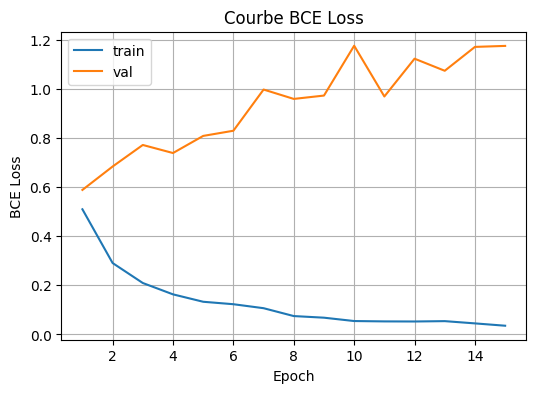

In [18]:
# Courbes d’apprentissage
plot_curves(train_losses, val_losses, ylabel="BCE Loss")


AUC test: 0.745 | F1 test: 0.648


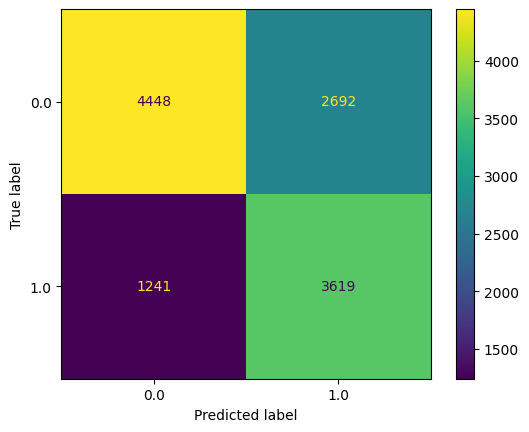

In [19]:
# ----- 11. Évaluation finale sur test -----
_, test_auc, test_f1 = eval_epoch(model_final, test_dl, nn.BCEWithLogitsLoss())
print(f"AUC test: {test_auc:.3f} | F1 test: {test_f1:.3f}")

# Confusion matrix
model_final.eval()
preds, labels = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        preds.append(torch.sigmoid(model_final(xb.to(device))).cpu())
        labels.append(yb)
preds = torch.cat(preds).numpy()
labels= torch.cat(labels).numpy()
ConfusionMatrixDisplay.from_predictions(labels, preds>0.5)
plt.show()


In [20]:
# ----- 12. Sauvegarde -----
torch.save(state, MODEL_DIR / f"{RUN_NAME}_weights.pt")
with open(MODEL_DIR / f"{RUN_NAME}_params.json", "w") as fp:
    json.dump(study.best_params, fp, indent=2)
print("Artifacts saved in", MODEL_DIR)


Artifacts saved in Pytorch_models


In [21]:
# ----- 13. Exemple d’inférence -----
sample = np.random.rand(430).reshape(1, -1)
with torch.no_grad():
    prob = torch.sigmoid(model_final(torch.tensor(sample, dtype=torch.float32).to(device))).item()
print(f"Probabilité malade: {prob:.3f}")


Probabilité malade: 0.025


In [22]:
# ----- 14. Explainability (facultatif) -----
# import shap
# explainer = shap.DeepExplainer(model_final, torch.tensor(X_train[:100]).to(device))
# shap_values = explainer.shap_values(torch.tensor(sample_std).to(device))
# shap.summary_plot(shap_values, features=sample_std)
